In [1]:
'''
Script to extract and visualize job results from IBM and IQM.
'''

import numpy as np
from qiskit import transpile
from func_qc import qc_backend, get_ancillaqubit
import func_matrix_vector as matvec
from qiskit import qpy
import os
import argparse
import pickle
import json
from qiskit_ibm_runtime import RuntimeEncoder

parser = argparse.ArgumentParser()
parser.add_argument("-case", "--case_name",  type=str, default='ideal', required=False, help="Name of the problem case: 'sample-tridiag', 'hele-shaw'")
parser.add_argument("-casefile", "--case_variable_file",  type=str, default='ideal', required=False, help="YAML file containing variables for the case: 'input_vars.yaml'")

parser.add_argument("-s", "--SHOTS", type=int, default=1000, required=True, help="Numer of shots for the simulator.")
parser.add_argument("--gpu", default=False, action='store_true', help="Use GPU backend for Aer simulator.")
parser.add_argument("--gpumultiple", default=False, action='store_true', help="Use multiple GPUs for the backend of Aer simulator.")
parser.add_argument("-backtyp", "--backend_type",  type=str, default='ideal', required=False, help="Type of the backend: 'ideal' 'real-ibm'")
parser.add_argument("-backmet", "--backend_method",  type=str, default='statevector', required=False, help="Method/name of the backend. E.g. 'statevector' 'fake_sherbrooke' 'ibm_sherbrooke'")
parser.add_argument("--drawcirc", default=False, action='store_true', help="Draw circuit.")
parser.add_argument("--plothist", default=False, action='store_true', help="Draw circuit.")

parser.add_argument("--savedata", default=False, action='store_true', help="Save data at `models/<filename>` with `<filename>` based on parameters.")
parser.add_argument("--loadcirctranspile", default=False, action='store_true', help="Load transpiled circuit at `models/<filename>` with `<filename>` based on parameters.")

# Case details
# NOTE: CHANGE these according to your case
args = parser.parse_args(['-s 500'])
args.case_name = 'sample-tridiag'
args.case_variable_file = 'input_vars.yaml'
args.backend_type = 'real-iqm' 
args.backend_method = 'garnet:mock'
job_id = '0679c02a-bcc8-7fc9-8000-667918983e72'
from dotenv import load_dotenv
load_dotenv("keys.sh")

True

In [2]:
# ### Get system matrix and vector
matrix, vector, input_vars = matvec.get_matrix_vector(args)

# ### Setup quantum backend
backend_type = args.backend_type
backend_method = args.backend_method
if backend_type=='real-ibm':
    from qiskit_ibm_runtime import QiskitRuntimeService
    # save your IBMProvider accout for future loading
    API_KEY = os.getenv('IBMQ_API_KEY')
    instance = os.getenv('IBMQ_INSTANCE')
    # save your QiskitRuntimeService accout for future loading
    QiskitRuntimeService.save_account(
        channel="ibm_quantum",
        instance=instance,
        token=API_KEY,
        overwrite=True
    )
    service = QiskitRuntimeService()  # To get back results
    backend = service.backend(backend_method)
    job = service.job(job_id)
elif backend_type=='real-iqm':
        from iqm.qiskit_iqm import IQMProvider
        # save your IQM account for future loading
        API_KEY = os.getenv('IQM_API_KEY') # ${IQM_TOKEN} can't be set when using `token` parameter below
        server_url = f"https://cocos.resonance.meetiqm.com/{backend_method}"
        backend = IQMProvider(server_url, token=API_KEY).get_backend()
        from iqm.qiskit_iqm.iqm_job import IQMJob
        job = IQMJob(backend, job_id)
else:
    raise Exception(f'Backend type \'{backend_type}\' not implemented.')

# ### Retrieve Results
result = job.result()
counts_device = result.get_counts()
print(counts_device)

Case: Sample tridiagonal
{'10100': 258, '00000': 249, '01011': 263, '11111': 230}


In [3]:
# ### Get circuit (Can skip this if you only want to get the counts from the job. This is used to compare the results with that from a simulator.)
n_qubits_matrix = int(np.log2(matrix.shape[0]))
counts_ancilla, _, _, counts_vector = get_ancillaqubit(counts_device, n_qubits_matrix)

filename = input_vars['savefilename'].format(**input_vars)
savefilename = f'{filename}_circ_nqmatrix{n_qubits_matrix}'
with open(f'{savefilename}.qpy', 'rb') as fd:
    circ = qpy.load(fd)[0]
circ.measure_all()
circ = transpile(circ, backend)
n_shots = args.SHOTS
# ### Save Results
savefilename = f'{filename}_circ-fullresults_nqmatrix{n_qubits_matrix}_backend-{args.backend_method}_shots{n_shots}.pkl'
save_data = {   'args'                      : args,
                'input_vars'                : input_vars,
                'counts'                    : counts_device,
                'counts_ancilla'            : counts_ancilla,
                'counts_vector'             : counts_vector,
                'result'                    : result}
file = open(savefilename, 'wb')
pickle.dump(save_data, file)
file.close()
print("===========Full data saved===========")

===========Full data saved===========


{'10001': 19, '00000': 91, '10000': 292, '00001': 98}


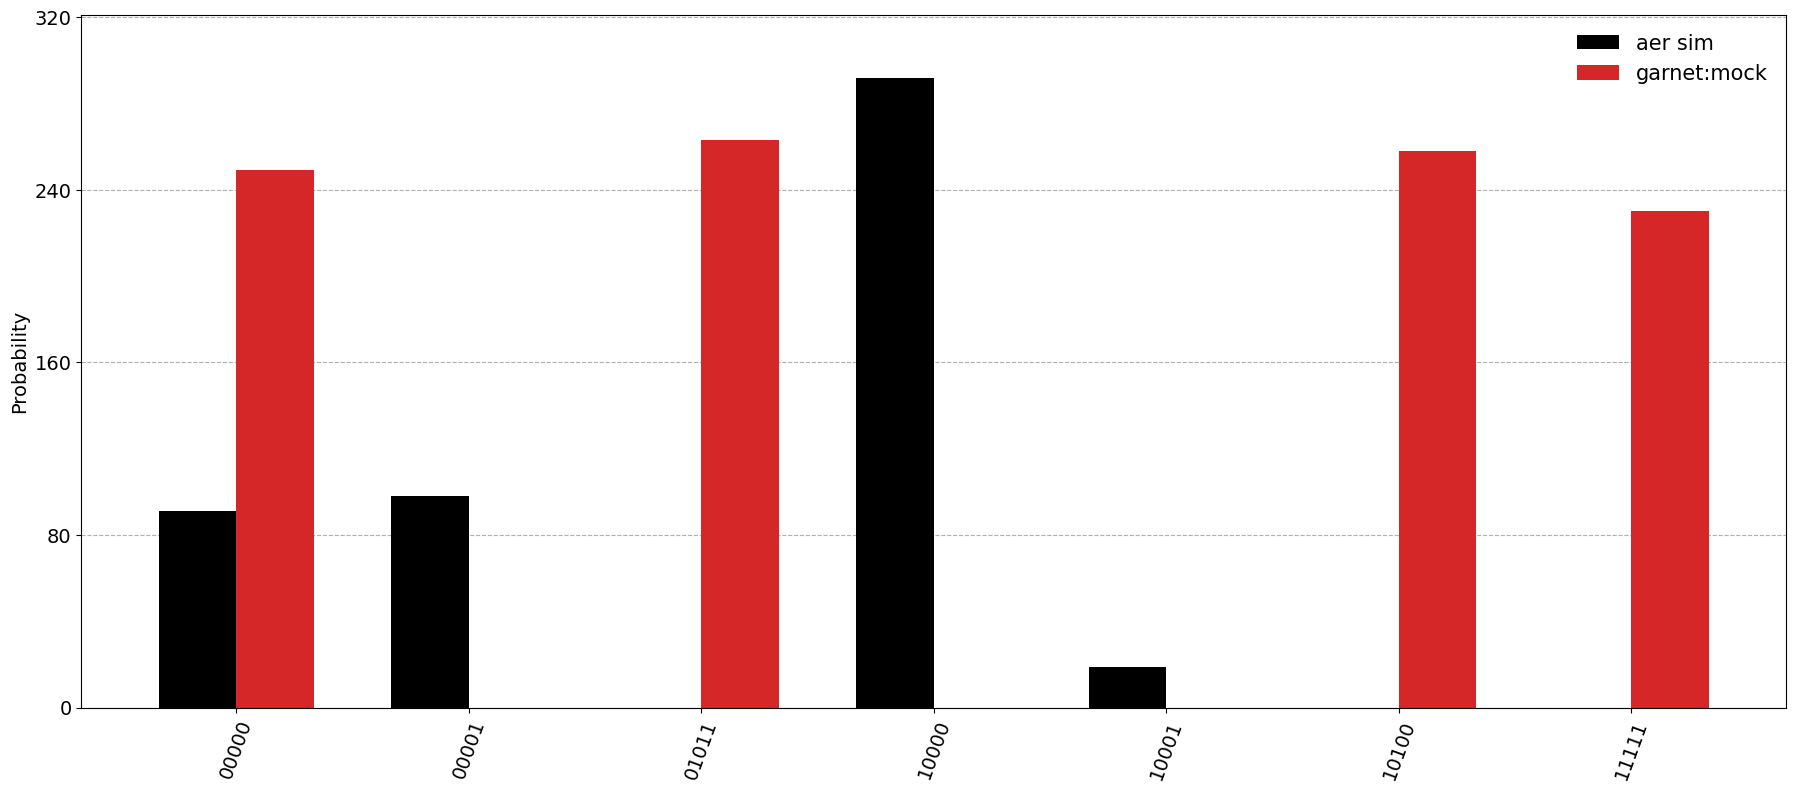

In [4]:
# Run circuit on simulator to compare results
backend = qc_backend('ideal', 'statevector', args)
counts_aer = backend.run(circ, shots=n_shots).result().get_counts()
print(counts_aer)

import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
counts = [counts_aer, counts_device]
cases = 2
legend_list = [
        "aer sim",
        backend_method
    ]
xtick_labels = ['aer', backend_method]
color_list = ['k', 'tab:red', 'tab:green', 'tab:blue', 'tab:cyan']

plt.rcParams.update({'font.size': 15})
fig, ax1 = plt.subplots(1,1,figsize=(22,9), facecolor="1")
plot_histogram(
    counts,
    color = color_list[0:cases],
    bar_labels=False,
    legend=legend_list[0:cases],
    ax=ax1,
)
ax1.set_ylabel('Probability')
ax1.legend(loc='best', frameon=False);